# NLP with Disaster Tweets


**Introduction:**

Twitter has become  an  important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce  an  emergency  they’re  observing  in real-time. Because of this, more agencies are interested in programmatically monitoring  Twitter (i.e. disaster relief organizations and news agencies). But it’s  not always clear whether a person’s words are actually announcing a disaster.

In this project, I am challenged to build a model that predicts which Tweets are about real disasters and which one’s aren’t. The dataset consists of 10,000 tweets that were hand classified.



## Load and Check data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# importing libraries
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
import random
import IPython
import IPython.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
import tensorflow as tf
import joblib

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
# load the .csv file's - update the file location as needed!!
tweets_train= pd.read_csv('/content/drive/MyDrive/text_classification/data/raw/train.csv')
tweets_test=pd.read_csv('/content/drive/MyDrive/text_classification/data/raw/test.csv')
tweets_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shape of data
print(f"Train data: No. of rows - {tweets_train.shape[0]}, No. of columns - {tweets_train.shape[1]}")
print(f"Test data : No. of rows - {tweets_test.shape[0]}, No. of columns - {tweets_test.shape[1]}")

Train data: No. of rows - 7613, No. of columns - 5
Test data : No. of rows - 3263, No. of columns - 4


## Preliminary Analysis

###  Data Overview

In [ ]:
# Let's print out tweets for both targets - (Disaster & Not a Disaster)
print(f"Disaster Tweet: {random.choice(tweets_train[tweets_train['target']==1]['text'].tolist())}")
print(f"\nNon-Disaster Tweet: {random.choice(tweets_train[tweets_train['target']==0]['text'].tolist())}")


Disaster Tweet: CLIMATE CONSEQUENCES: U.S. Forest Service Says Spending More Than Half Of Budget On Fires http://t.co/k0QtL8aODH http://t.co/zQBXe7x9Y7

Non-Disaster Tweet: Businesses abe deluged with invoices. Make yours stand out with colour or shape and it's likely to rise to the top of the pay';pile.


In [ ]:
# % of missing values
percent_missing = round((tweets_train.isnull().sum()*100)/tweets_train.shape[0],2)
print(f"Percent of Missing values:\n{percent_missing}")

Percent of Missing values:
id           0.00
keyword      0.80
location    33.27
text         0.00
target       0.00
dtype: float64


- The columns 'keyword' and 'location' have missing values (0.8% and 33.27% respectively), while other columns are complete.

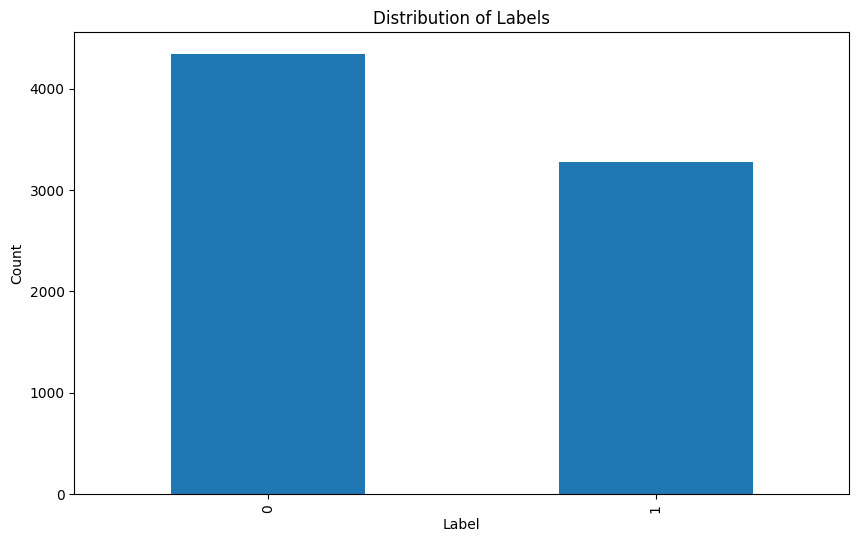

In [ ]:
# Visualize the target distribution
plt.figure(figsize=(10, 6))
tweets_train['target'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

- The dataset is slightly imbalanced, with more non-disaster tweets than disaster tweets. This imbalance isn't severe, but it's noticeable enough that it might need to be considered during model training and evaluation.

### Text Length Analysis

Performing text length analysis at both the word and character levels is crucial and a fundamental step in NLP.

Word-level analysis assesses document complexity and readability, while character-level analysis aids in data preprocessing and provides granular insights

#### Word level analysis


In [ ]:
# Calculate word counts
word_counts_0 = tweets_train[tweets_train['target']==0]['text'].str.split().map(lambda x: len(x))
word_counts_1 = tweets_train[tweets_train['target']==1]['text'].str.split().map(lambda x: len(x))

print("\nWord-level statistics (Target:0):")
print(word_counts_0.describe())

print("\nWord-level statistics (Target:1):")
print(word_counts_1.describe())


Word-level statistics (Target:0):
count    4342.000000
mean       14.704744
std         6.161564
min         1.000000
25%        10.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text, dtype: float64

Word-level statistics (Target:1):
count    3271.000000
mean       15.167533
std         5.096806
min         2.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        30.000000
Name: text, dtype: float64


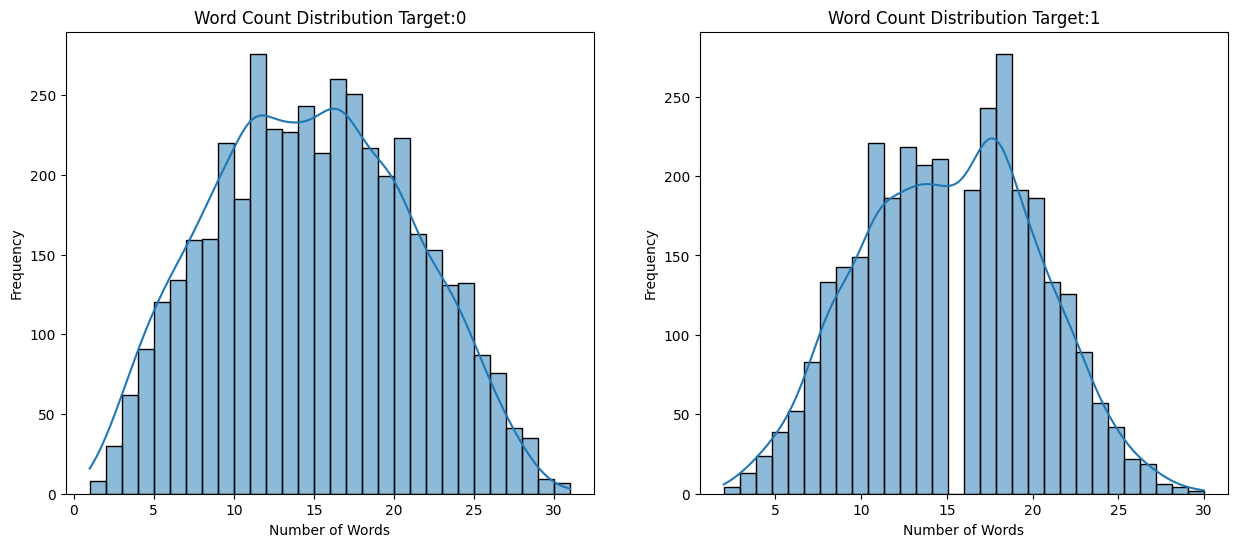

In [ ]:
# Visualize word count distribution
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(word_counts_0, kde=True, bins=30,ax=ax1)
sns.histplot(word_counts_1, kde=True, bins=30,ax=ax2)

ax1.set_title(f'Word Count Distribution Target:0')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Frequency')
ax2.set_title(f'Word Count Distribution Target:1')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')

plt.show()

**Word Count Insights:**
- Disaster tweets tend to be slightly longer on average, but with less variation in length.
- Both categories have similar median lengths and interquartile ranges.
- There are very few extremely short (<5 words) or long (>25 words) tweets in either category.

In [ ]:
# Average word length (which is the same as characters per word)
avg_word_length_0 = tweets_train[tweets_train['target']==0]['text'].apply(lambda x: np.mean([len(word) for word in x.split() if word]))
avg_word_length_1 = tweets_train[tweets_train['target']==1]['text'].apply(lambda x: np.mean([len(word) for word in x.split() if word]))

print("\nAverage word length statistics (Target:0):")
print(avg_word_length_0.describe())

print("\nAverage word length statistics (Target:1):")
print(avg_word_length_1.describe())


Average word length statistics (Target:0):
count    4342.000000
mean        5.871325
std         1.742150
min         2.250000
25%         4.600000
50%         5.538462
75%         6.818182
max        16.857143
Name: text, dtype: float64

Average word length statistics (Target:1):
count    3271.000000
mean        6.469866
std         1.516937
min         3.000000
25%         5.476190
50%         6.352941
75%         7.312500
max        19.333333
Name: text, dtype: float64


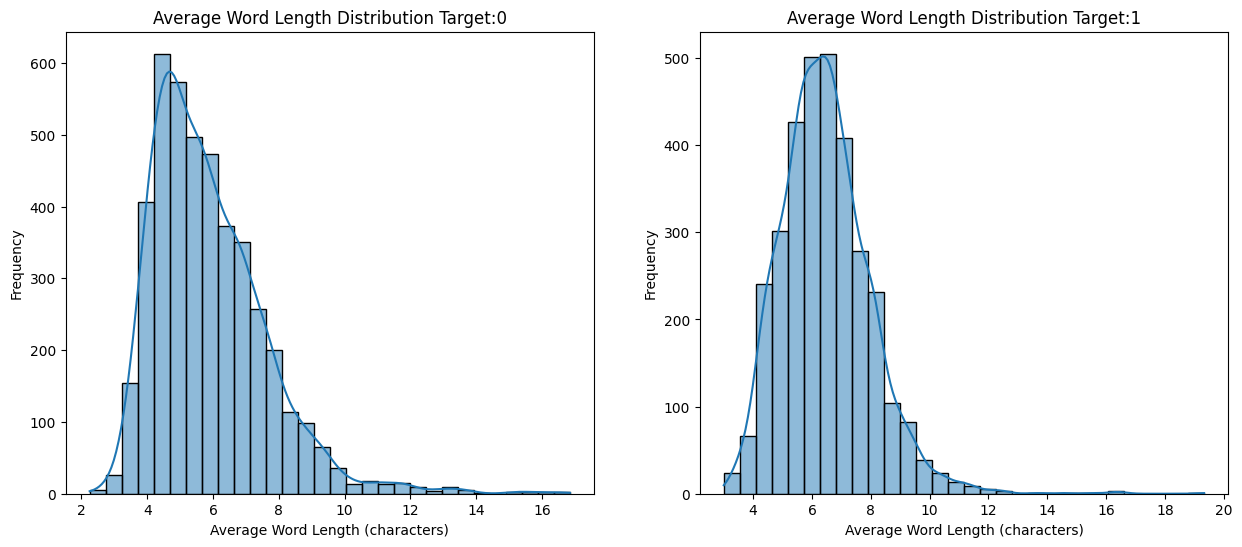

In [ ]:
# Visualize average word length distribution
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(avg_word_length_0, kde=True, bins=30,ax=ax1)
sns.histplot(avg_word_length_1, kde=True, bins=30,ax=ax2)

ax1.set_title(f'Average Word Length Distribution Target:0')
ax1.set_xlabel('Average Word Length (characters)')
ax1.set_ylabel('Frequency')
ax2.set_title(f'Average Word Length Distribution Target:1')
ax2.set_xlabel('Average Word Length (characters)')
ax2.set_ylabel('Frequency')

plt.show()


**Average Word Length Insights:**
- Disaster-related tweets tend to use slightly longer words on average.
- The most common average word lengths for both categories are between 5-7 characters.
- There are very few tweets with average word lengths above 10 characters in either category.

#### Character Level Analysis

In [ ]:
# Character count (including spaces)
char_count_0 = tweets_train[tweets_train['target']==0]['text'].str.len()
char_count_1 = tweets_train[tweets_train['target']==1]['text'].str.len()


print("\nCharacter-level statistics (including spaces) (Target:0):")
print(char_count_0.describe())
print("\nCharacter-level statistics (including spaces) (Target:1):")
print(char_count_1.describe())


Character-level statistics (including spaces) (Target:0):
count    4342.000000
mean       95.706817
std        35.885924
min         7.000000
25%        68.000000
50%       101.000000
75%       130.000000
max       157.000000
Name: text, dtype: float64

Character-level statistics (including spaces) (Target:1):
count    3271.000000
mean      108.113421
std        29.309854
min        14.000000
25%        88.000000
50%       115.000000
75%       136.000000
max       151.000000
Name: text, dtype: float64


Text(0, 0.5, 'Frequency')

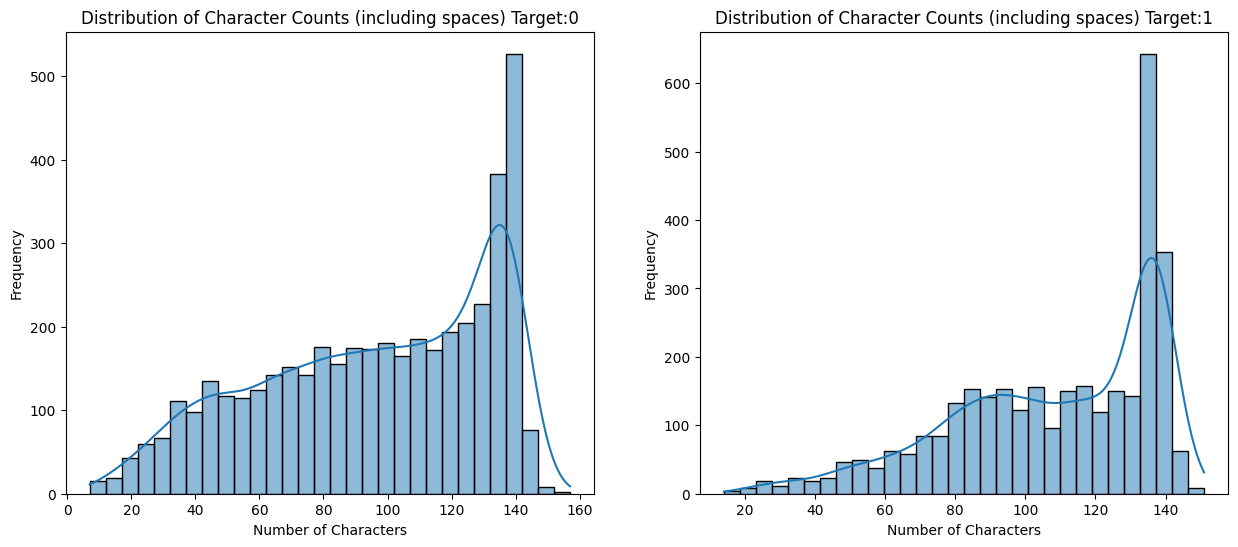

In [ ]:
# Visualize character count distribution (including spaces)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(char_count_0, kde=True, bins=30,ax=ax1)
sns.histplot(char_count_1, kde=True, bins=30,ax=ax2)

ax1.set_title(f'Distribution of Character Counts (including spaces) Target:0')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Frequency')

ax2.set_title(f'Distribution of Character Counts (including spaces) Target:1')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Frequency')


In [ ]:
# Character count (excluding spaces)
char_count_no_space_0 = tweets_train[tweets_train['target']==0]['text'].apply(lambda x: len(x.replace(" ", "")))
char_count_no_space_1 = tweets_train[tweets_train['target']==1]['text'].apply(lambda x: len(x.replace(" ", "")))

print("\nCharacter-level statistics (excluding spaces) (Target:0):")
print(char_count_no_space_0.describe())
print("\nCharacter-level statistics (excluding spaces) (Target:1):")
print(char_count_no_space_1.describe())


Character-level statistics (excluding spaces) (Target:0):
count    4342.000000
mean       81.982957
std        30.798207
min         6.000000
25%        58.000000
50%        87.000000
75%       110.000000
max       138.000000
Name: text, dtype: float64

Character-level statistics (excluding spaces) (Target:1):
count    3271.000000
mean       93.912259
std        25.255694
min        13.000000
25%        77.000000
50%       100.000000
75%       116.500000
max       134.000000
Name: text, dtype: float64


Text(0, 0.5, 'Frequency')

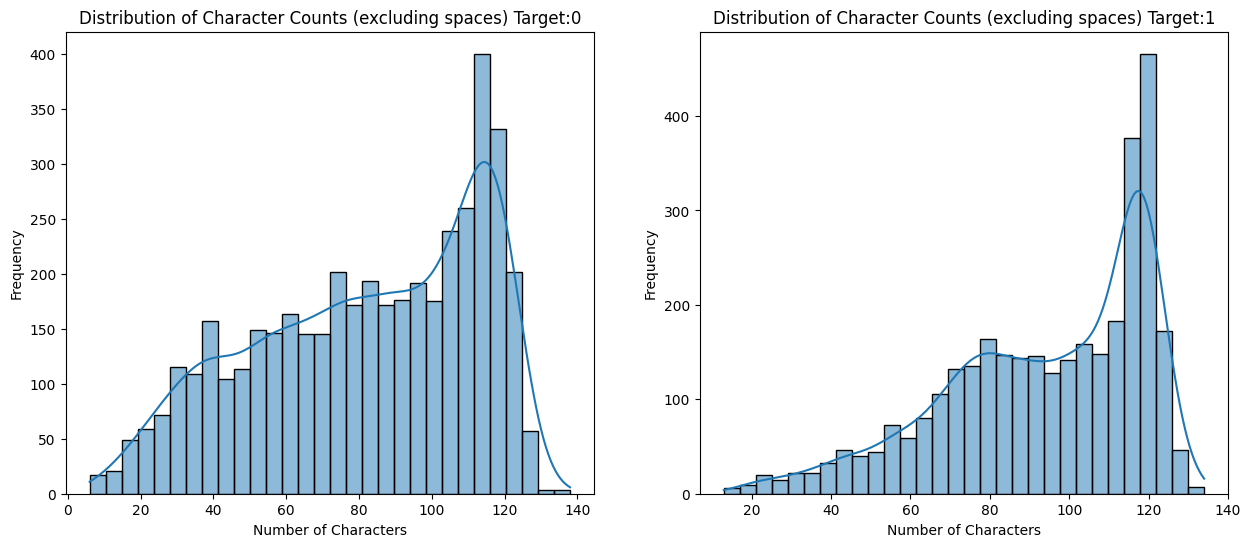

In [ ]:
# Visualize character count distribution (excluding spaces)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(char_count_no_space_0, kde=True, bins=30,ax=ax1)
sns.histplot(char_count_no_space_1, kde=True, bins=30,ax=ax2)

ax1.set_title(f'Distribution of Character Counts (excluding spaces) Target:0')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Frequency')

ax2.set_title(f'Distribution of Character Counts (excluding spaces) Target:1')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Frequency')


**Including spaces:**
- Non-Disaster Tweets have a lower mean character count, more variability and has a wider range compared to Disaster Tweets .

**Excluding spaces:**
- The pattern is similar when excluding spaces.
- Non-Disaster Tweets have a lower mean, still shows more variability and has a wider range compared to Disaster Tweets .

**Distribution shapes:**
- Non-Disaster Tweets distributions are more spread out and slightly right-skewed.
- Disaster Tweets distributions are more concentrated and have a more pronounced peak.

**Space usage:**
- On average, Non-Disaster Tweets uses about 14 spaces (95.7 - 81.98) per text.
- Disaster Tweets also uses about 14 spaces (108.1 - 93.9) per text on average.

**Median values:**
- The median for Non-Disaster Tweets is lower than Disaster Tweets in both cases, indicating that Disaster Tweets texts are generally longer.



## Text Preprocessing

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.

### Data Cleaning - Removing Noise

Removing Noise -- everything that isn’t in a standard number or letter i.e url's, Punctuation, standalone numbers, hashtags & mentions etc..

Also make sure to conver the text to lowercase so that the algorithm does not treat the same words in different cases as different.

In [9]:
def clean_text(text):
      # convert text to lowercase
      text = text.lower()
      # remove url's
      text = re.sub('https?://\S+|www\.\S+', '', text)
      # Handle website names (e.g., HorrorMovies.ca)
      text = re.sub(r'\b[A-Za-z0-9-]+\.[a-z]{2,}\b', '', text)
      # remove html tags
      text = re.sub('<.*?>+', '', text)
      # Handle hashtags: remove the # symbol but keep the text
      text = re.sub(r'#(\w+)', r'\1', text)
      # Handle mentions: remove @ symbol and username
      text = re.sub(r'@\w+', '', text)
      # Remove emojis and special characters
      text = text.encode('ascii', 'ignore').decode('ascii')
      # Remove standalone numbers, but keep numbers within words
      text = re.sub(r'\b\d+\b', '', text)
      # Remove square brackets
      text = text.replace('[', '').replace(']', '')
      # Remove punctuation, but keep apostrophes within words and hyphens between words
      text = re.sub(r"[^\w\s'-]|(?<!\w)['|-]|['|-](?!\w)", '', text)
      # Remove extra whitespace
      text = re.sub(r'\s+', ' ', text).strip()

      return text


In [10]:
# Applying the cleaning function to both train & test datasets
tweets_train['text'] = tweets_train['text'].apply(lambda x: clean_text(x))
tweets_test['text'] = tweets_test['text'].apply(lambda x: clean_text(x))

In [ ]:
# Let's take a look at the updated text
for i in range(5):
    print(f"Tweet{i}: {tweets_train['text'][i]}")

Tweet0: our deeds are the reason of this earthquake may allah forgive us all
Tweet1: forest fire near la ronge sask canada
Tweet2: all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
Tweet3: people receive wildfires evacuation orders in california
Tweet4: just got sent this photo from ruby alaska as smoke from wildfires pours into a school


### Tokenization

Process of converting the normal text strings into a list of tokens(words)!!

In [11]:
wt = WhitespaceTokenizer()
# Applying the word_tokenize to both train & test datasets
tweets_train['text'] = tweets_train['text'].apply(lambda x: wt.tokenize(x))
tweets_test['text'] = tweets_test['text'].apply(lambda x: wt.tokenize(x))

In [ ]:
# Let's take a look at the tokenized text
for i in range(5):
    print(f"Tokenized Tweet{i}: {tweets_train['text'][i]}")

Tokenized Tweet0: ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Tokenized Tweet1: ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']
Tokenized Tweet2: ['all', 'residents', 'asked', 'to', 'shelter', 'in', 'place', 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected']
Tokenized Tweet3: ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'in', 'california']
Tokenized Tweet4: ['just', 'got', 'sent', 'this', 'photo', 'from', 'ruby', 'alaska', 'as', 'smoke', 'from', 'wildfires', 'pours', 'into', 'a', 'school']


### StopWords Removal

Words that occur frequently don't contribute much meaningful information to the overall context of a text. It's better to get rid of them.

In [12]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text if word not in stop_words]

    return tokens

In [13]:
# Applying stopwords to both train & test datasets
tweets_train['text'] = tweets_train['text'].apply(lambda x: remove_stopwords(x))
tweets_test['text'] = tweets_test['text'].apply(lambda x: remove_stopwords(x))

In [ ]:
# Let's take a look at the text
for i in range(5):
    print(f"Tokenized Tweet{i}: {tweets_train['text'][i]}")

Tokenized Tweet0: ['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']
Tokenized Tweet1: ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']
Tokenized Tweet2: ['residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected']
Tokenized Tweet3: ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'california']
Tokenized Tweet4: ['got', 'sent', 'photo', 'ruby', 'alaska', 'smoke', 'wildfires', 'pours', 'school']


### Lemmatization

Often we have similar kinds of words (like eat, eaten and got, get) in the text. As they increase the complexity we can reduce the words to their root word (lemma) by using lemmatization.

In [14]:
def apply_lemmatize(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word,pos='v') for word in text]

    return tokens

In [15]:
# Applying Lemmatization to both train & test datasets
tweets_train['text'] = tweets_train['text'].apply(lambda x: apply_lemmatize(x))
tweets_test['text'] = tweets_test['text'].apply(lambda x: apply_lemmatize(x))

In [ ]:
# Let's take a look at the text
for i in range(5):
    print(f"Lemmatized Tweet{i}: {tweets_train['text'][i]}")

Lemmatized Tweet0: ['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']
Lemmatized Tweet1: ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']
Lemmatized Tweet2: ['residents', 'ask', 'shelter', 'place', 'notify', 'officer', 'evacuation', 'shelter', 'place', 'order', 'expect']
Lemmatized Tweet3: ['people', 'receive', 'wildfires', 'evacuation', 'order', 'california']
Lemmatized Tweet4: ['get', 'send', 'photo', 'ruby', 'alaska', 'smoke', 'wildfires', 'pour', 'school']


### Combining Text

After pre-processing, for futher analysis we nned to convert the list of words into text (or string). We can do that by using .join().

In [16]:
# converting list of strings to single string
tweets_train['text'] = tweets_train['text'].apply(lambda x: ' '.join(x))
tweets_test['text'] = tweets_test['text'].apply(lambda x: ' '.join(x))

In [ ]:
print(f"Text After Pre-processing: {tweets_train['text'][0]}")

Text After Pre-processing: deeds reason earthquake may allah forgive us


In [ ]:
# saving the cleaned tweets dataframe
tweets_train.to_csv('/content/drive/MyDrive/text_classification/data/cleaned/train_cleaned.csv',index=False)

## Text Vectorization

After the initial preprocessing phase, we need to transform text into a meaningful vector (or array) of numbers, which is done using below techniques:

### Bag-Of-Words (BOW)

Bag-of-words (BoW) vector representation is the most simple to understand traditional vector representation. Each word is linked to a vector index, and a vector element contains the number of occurrences of each word in a given document.

In [17]:
# generating a bag-of-words representation using the Scikit Learn
count_vectorizer = CountVectorizer()
train_bow = count_vectorizer.fit_transform(tweets_train['text'])
test_bow = count_vectorizer.transform(tweets_test["text"])

In [ ]:
print(f"BOW representation of text: {test_bow[0]}")

BOW representation of text:   (0, 1905)	1
  (0, 2661)	1
  (0, 5046)	1
  (0, 11273)	1


### Term Frequency - Inverse Document Frequency (TF-IDF)

In BoW representation, word occurrences are weighted using the same technique regardless of the word itself. TF-IDF is a variation of bag-of-words, where instead of a binary 0/1 value indicating the appearance of a word in a document, a floating-point value is used, which is related to the frequency of the word occurrence in the corpus.

In [18]:
# creating TF-IDF vectorization of text using Scikit Learn
tfidf = TfidfVectorizer(ngram_range=(1, 2)) # ngram_range=(1, 2) will consider both unigrams and bigrams
train_tfidf = tfidf.fit_transform(tweets_train['text'])
test_tfidf = tfidf.transform(tweets_test["text"])

In [ ]:
print(f"TF-IDF representation of text: {train_tfidf[0]}")

TF-IDF representation of text:   (0, 19283)	0.32011756386261175
  (0, 1582)	0.32011756386261175
  (0, 30914)	0.2961155881478901
  (0, 15085)	0.32011756386261175
  (0, 40030)	0.32011756386261175
  (0, 12697)	0.32011756386261175
  (0, 52054)	0.1690342295143317
  (0, 19277)	0.27673747491550243
  (0, 1580)	0.2643867021177953
  (0, 30912)	0.18947616625864822
  (0, 15072)	0.21230421493040946
  (0, 40024)	0.224109661003725
  (0, 12696)	0.30607730812627965


## ML Model Building

Now that the data is ready for modelling, let's use some common Machine Learning models such as Logistic regression and Naive Bayes to see how they perform text classification.

To improve the robustness of our models, I am using a 5-fold cross-validation technique, for generalizable evaluation of performance across critical measures like as accuracy, precision, recall, and F1-score.

In [19]:
# Setup Crossval classifier scorers
scorers = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1': 'f1'
}
rand_st = 111 # random seed

### Logistic Regression + BOW

In [ ]:
# Fitting Logistic regression on Bag of Words
clf1 = LogisticRegression(random_state=rand_st)
clf1.fit(train_bow,tweets_train['target'])
scores = cross_validate(estimator=clf1, X=train_bow, y=tweets_train['target'], scoring=scorers, cv=5)

# Print the scores
print("Logistic Regression on BOW:")
for metric in scorers.keys():
    print(f"{metric}: %0.2f (+/- %0.2f)" % (scores[f'test_{metric}'].mean(), scores[f'test_{metric}'].std() * 2))

Logistic Regression on BOW:
Accuracy: 0.69 (+/- 0.08)
Precision: 0.68 (+/- 0.15)
Recall: 0.54 (+/- 0.17)
F1: 0.60 (+/- 0.11)


### Logistic Regression + TF-IDF

In [ ]:
# Fitting Logistic regression on TF-IDF
clf2 = LogisticRegression(random_state=rand_st)
clf2.fit(train_tfidf,tweets_train['target'])
scores = cross_validate(estimator=clf2, X=train_tfidf, y=tweets_train['target'], scoring=scorers, cv=5)

# Print the scores
print("Logistic Regression on TF-IDF:")
for metric in scorers.keys():
    print(f"{metric}: %0.2f (+/- %0.2f)" % (scores[f'test_{metric}'].mean(), scores[f'test_{metric}'].std() * 2))

Logistic Regression on TF-IDF:
Accuracy: 0.69 (+/- 0.09)
Precision: 0.82 (+/- 0.16)
Recall: 0.37 (+/- 0.18)
F1: 0.50 (+/- 0.19)


- The TF-IDF representation significantly improves precision but at the cost of lower recall, while BOW provides a more balanced performance.
- Both models show high variability in performance metrics, particularly in recall and F1 score.

### Naive Bayes Classifier + BOW

In [ ]:
# Fitting Multinomial Navie Bayes Classifier on Bag of Words
clf3 = MultinomialNB()
clf3.fit(train_bow,tweets_train['target'])
scores = cross_validate(estimator=clf3, X=train_bow, y=tweets_train['target'], scoring=scorers, cv=5)

# Print the scores
print("Multinomial Navie Bayes on BOW:")
for metric in scorers.keys():
    print(f"{metric}: %0.2f (+/- %0.2f)" % (scores[f'test_{metric}'].mean(), scores[f'test_{metric}'].std() * 2))

Multinomial Navie Bayes on BOW:
Accuracy: 0.70 (+/- 0.07)
Precision: 0.64 (+/- 0.09)
Recall: 0.68 (+/- 0.17)
F1: 0.66 (+/- 0.08)


### Navie Bayes Classifier + TF-IDF

In [20]:
# Fitting Multinomial Navie Bayes Classifier on TF-IDF
clf4 = MultinomialNB()
clf4.fit(train_tfidf,tweets_train['target'])
scores = cross_validate(estimator=clf4, X=train_tfidf, y=tweets_train['target'], scoring=scorers, cv=5)

# Print the scores
print("Multinomial Navie Bayes on TF-IDF:")
for metric in scorers.keys():
    print(f"{metric}: %0.2f (+/- %0.2f)" % (scores[f'test_{metric}'].mean(), scores[f'test_{metric}'].std() * 2))

Multinomial Navie Bayes on TF-IDF:
Accuracy: 0.72 (+/- 0.07)
Precision: 0.76 (+/- 0.10)
Recall: 0.51 (+/- 0.16)
F1: 0.60 (+/- 0.12)


- While TF-IDF shows higher precision, BOW demonstrates better recall and a slightly higher F1 score, suggesting that BOW may be preferable if a balance between precision and recall is desired.
- The high standard deviations across all metrics indicate significant variability in model performance.

## Deep Learning with Word2Vec

**Enhancing our Text Classification approach:**

Transitioning from BoW/TF-IDF to Word2Vec will create dense vector representations, capturing rich semantic relationships. We'll train a Word2Vec model on our dataset, tailoring embeddings to our specific domain for improved context understanding. To capture the meaning of text sequences, we'll use neural network architectures, leveraging these embeddings as inputs to provide a stronger foundation in language understanding.

Our goal is to enhance model performance by combining semantic embeddings with neural networks.

### Training CBoW Model

In [ ]:
# architecture of CBoW network
vocab_size = 5000 # We set vocab_size to 5000 to limit computations a bit.

vectorizer = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size,input_shape=(1,))
embedder = keras.layers.Embedding(vocab_size,30,input_length=1)

model = keras.Sequential([
    embedder,
    keras.layers.Dense(vocab_size,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 30)             150000    
                                                                 
 dense (Dense)               (None, 1, 5000)           155000    
                                                                 
Total params: 305000 (1.16 MB)
Trainable params: 305000 (1.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# initialize the vectorizer and get out the vocabulary
texts = tweets_train['text'].tolist() # convert the pandas Series to a list or numpy array
vectorizer.adapt(texts) # call the adapt method to go through all text and build a vocabulary:
vocab = vectorizer.get_vocabulary()
print(vocab[:20])

['', '[UNK]', 'get', 'like', 'fire', 'im', 'amp', 'go', 'bomb', 'new', 'via', 'say', 'people', 'one', 'news', 'burn', 'kill', 'make', 'us', 'flood']


In [ ]:
# Main function that will compute CBoW word pairs from text. This function will allow us to specify window size, and will return a set of pairs - input and output word.
def to_cbow(sent,window_size=3):
    res = []
    for i,x in enumerate(sent):
        for j in range(max(0,i-window_size),min(i+window_size+1,len(sent))):
            if i!=j:
                res.append([sent[j],x])
    return res

In [ ]:
# go through all text, call to_cbow to get the list of word pairs, and add those pairs to X and Y.
X = []
Y = []
for i,x in enumerate(texts):
    for w1, w2 in to_cbow(vectorizer(x),window_size=1):
        X.append(tf.expand_dims(w1,0))
        Y.append(tf.expand_dims(w2,0))

In [ ]:
# convert that data to one dataset, and batch it for training
ds = tf.data.Dataset.from_tensor_slices((X,Y)).batch(256)

In [ ]:

model.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='sparse_categorical_crossentropy')
model.fit(ds,epochs=200)
IPython.display.clear_output()

In [ ]:
# Extract trained embeddings
word2vec_weights = model.layers[0].get_weights()[0]

### Simple RNN

In [ ]:
# Create a TensorFlow dataset from the text and target columns of the tweets_train DataFrame
ds1 = tf.data.Dataset.from_tensor_slices((tweets_train['text'], tweets_train['target']))

In [ ]:
# Shuffle the dataset
ds1 = ds1.shuffle(len(tweets_train['text'].values), reshuffle_each_iteration=False)

# Calculate the split index
train_size = int(0.8 * len(tweets_train['text'].values))

# Split the dataset into training and validation sets
train_dataset = ds1.take(train_size)
val_dataset = ds1.skip(train_size)

# Batch the datasets
train_dataset = train_dataset.batch(32)
val_dataset = val_dataset.batch(32)

In [ ]:
# EarlyStopping callback to halt training when validation loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=10,
                                                    mode='min')

In [ ]:
# architecture
rnn_model = keras.models.Sequential([
    vectorizer,
    keras.layers.Embedding(vocab_size, 30, weights=[word2vec_weights], trainable=False),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(2,activation='softmax')
])

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, None, 30)          150000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2016      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 152082 (594.07 KB)
Trainable params: 2082 (8.13 KB)
Non-trainable params: 150000 (585.94 KB)
_________________________________________________________________


In [ ]:
# compile & fit model
rnn_model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'], optimizer='SGD')
history = rnn_model.fit(train_dataset,validation_data=val_dataset,epochs=200,callbacks=[early_stopping])
IPython.display.clear_output()

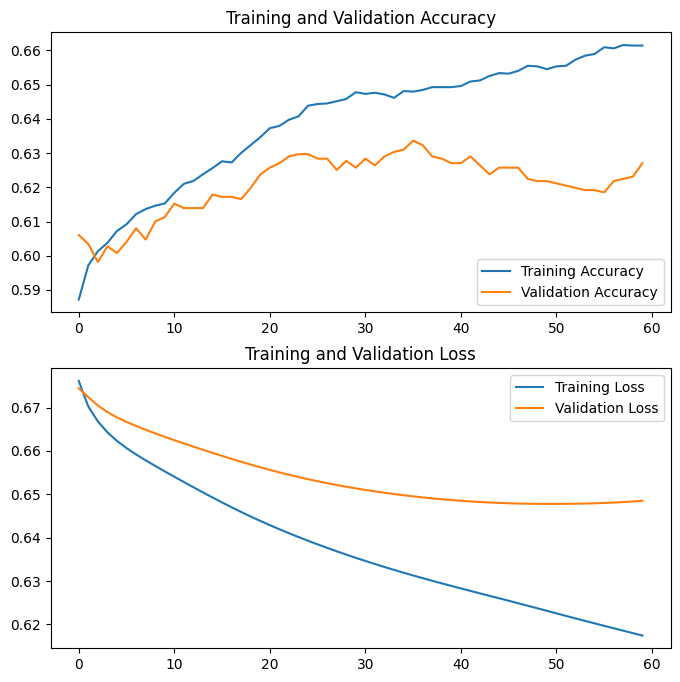

In [ ]:
# Visualize accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### LSTM (MultiLayer and Bidirectional)

In [ ]:
# architecture
lstm_model = keras.models.Sequential([
    vectorizer,
    keras.layers.Embedding(vocab_size, 30, weights=[word2vec_weights], trainable=False),
    keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2,activation='softmax')
])

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, None, 30)          150000    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         48640     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                      

In [ ]:
# compile & fit model
lstm_model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'], optimizer='SGD')
history = lstm_model.fit(train_dataset,validation_data=val_dataset,epochs=200,callbacks=[early_stopping])
IPython.display.clear_output()

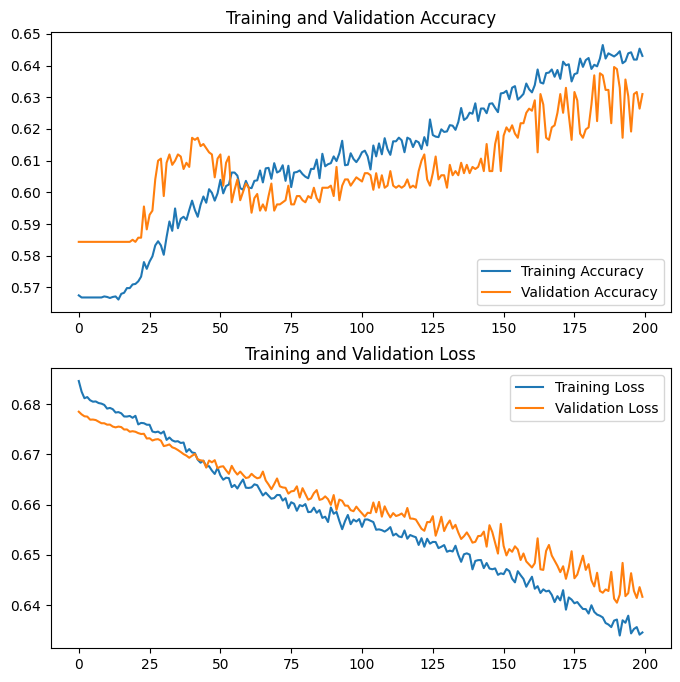

In [ ]:
# Visualize accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### GRU (MultiLayer and Bidirectional)

In [ ]:
# architecture
gru_model = keras.models.Sequential([
    vectorizer,
    keras.layers.Embedding(vocab_size, 30, weights=[word2vec_weights], trainable=False),
    keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.GRU(32)),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2,activation='softmax')
])

gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, None, 30)          150000    
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 128)         36864     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                      

In [ ]:
# compile & fit model
gru_model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'], optimizer='SGD')
history = gru_model.fit(train_dataset,validation_data=val_dataset,epochs=200,callbacks=[early_stopping])
IPython.display.clear_output()

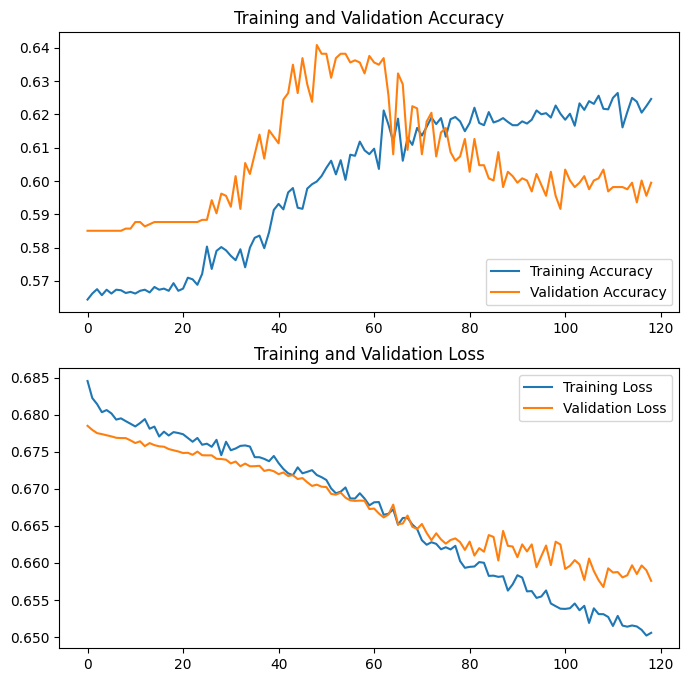

In [ ]:
# Visualize accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Make Predictions on Test data

**Predicting using LSTM**

In [ ]:
# make predictions
predictions = lstm_model.predict(tweets_test['text'])

102/102 [==============================] - 3s 11ms/step


In [ ]:
# Extract predictions based on a threshold of 0.5
predictions = (predictions[:, 1] >= 0.5).astype(int)
# Create a pandas DataFrame with IDs and predictions.
submission_df = pd.DataFrame({
    "id": tweets_test['id'],
    "target": predictions.flatten()})
# Save the DataFrame to a CSV file
submission_df.to_csv('/content/drive/MyDrive/text_classification/data/submissions/submission1.csv', index=False)

Submitting to Kaggle competition yielded a score of 0.62917

**Predicting using Logistic Regression on BOW**

In [ ]:
predictions2 = clf1.predict(test_bow)

In [ ]:
# Create a pandas DataFrame with IDs and predictions.
submission_df = pd.DataFrame({
    "id": tweets_test['id'],
    "target": predictions2})
# Save the DataFrame to a CSV file
submission_df.to_csv('/content/drive/MyDrive/text_classification/data/submissions/submission2.csv', index=False)

Submitting to Kaggle competition yielded a score of 0.79037

**Predicting using Logistic Regression on TF-IDF**

In [ ]:
predictions3 = clf2.predict(test_tfidf)

In [ ]:
# Create a pandas DataFrame with IDs and predictions.
submission_df = pd.DataFrame({
    "id": tweets_test['id'],
    "target": predictions3})
# Save the DataFrame to a CSV file
submission_df.to_csv('/content/drive/MyDrive/text_classification/data/submissions/submission3.csv', index=False)

Submitting to Kaggle competition yielded a score of 0.79834

**Predicting using Naive Bayes on BOW**

In [ ]:
predictions4 = clf3.predict(test_bow)

In [ ]:
# Create a pandas DataFrame with IDs and predictions.
submission_df = pd.DataFrame({
    "id": tweets_test['id'],
    "target": predictions4})
# Save the DataFrame to a CSV file
submission_df.to_csv('/content/drive/MyDrive/text_classification/data/submissions/submission4.csv', index=False)

Submitting to Kaggle competition yielded a score of 0.79497

**Predicting using Naive Bayes on TF-IDF**

In [ ]:
predictions5 = clf4.predict(test_tfidf)

In [ ]:
# Create a pandas DataFrame with IDs and predictions.
submission_df = pd.DataFrame({
    "id": tweets_test['id'],
    "target": predictions5})
# Save the DataFrame to a CSV file
submission_df.to_csv('/content/drive/MyDrive/text_classification/data/submissions/submission5.csv', index=False)

Submitting to Kaggle competition yielded a score of 0.79987

**Predicting using GRU**

In [ ]:
# make predictions
predictions6 = gru_model.predict(tweets_test['text'])

102/102 [==============================] - 3s 15ms/step


In [ ]:
# Extract predictions based on a threshold of 0.5
predictions6 = (predictions6[:, 1] >= 0.5).astype(int)
# Create a pandas DataFrame with IDs and predictions.
submission_df = pd.DataFrame({
    "id": tweets_test['id'],
    "target": predictions6.flatten()})
# Save the DataFrame to a CSV file
submission_df.to_csv('/content/drive/MyDrive/text_classification/data/submissions/submission6.csv', index=False)

Submitting to Kaggle competition yielded a score of 0.61507

**Visualizing Performance**

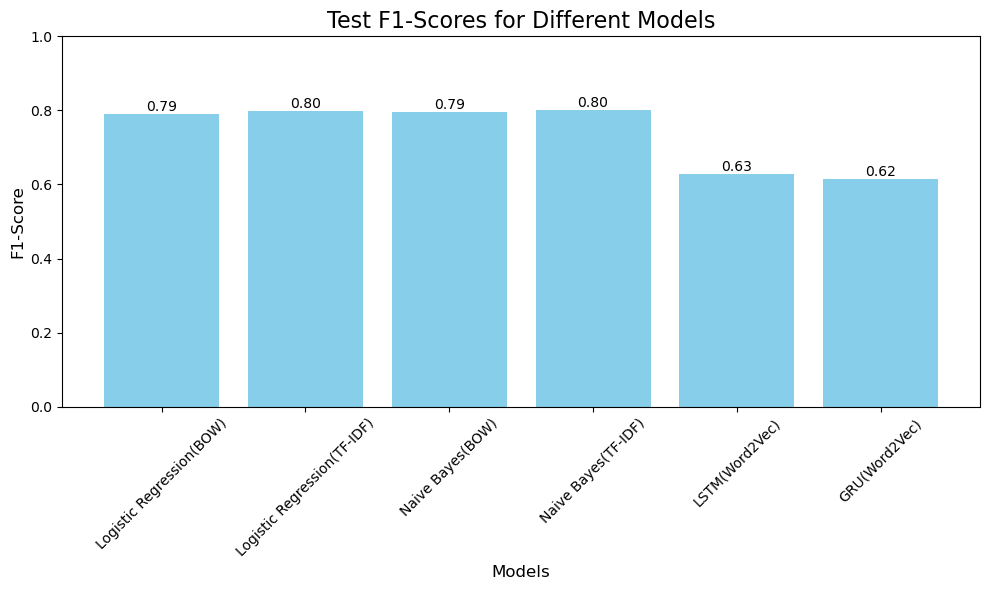

In [7]:
# Data
models = ['Logistic Regression(BOW)', 'Logistic Regression(TF-IDF)', 'Naive Bayes(BOW)', 'Naive Bayes(TF-IDF)','LSTM(Word2Vec)','GRU(Word2Vec)']
f1_scores = [0.79037, 0.79834, 0.79497, 0.79987, 0.62917, 0.61507]

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, f1_scores, color='skyblue')

# Customize the plot
plt.title('Test F1-Scores for Different Models', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.ylim(0, 1)  # F1-score range is 0 to 1
plt.xticks(rotation=45)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')


plt.tight_layout()

# Show the plot
plt.show()

## Save the Best Performing Model

In [21]:
# Save the vectorizer as a pickle in a file
joblib.dump(tfidf, '/content/drive/MyDrive/text_classification/models/vectorizer.pkl')

['/content/drive/MyDrive/text_classification/models/vectorizer.pkl']

In [22]:
# Save the model as a pickle in a file
joblib.dump(clf4, '/content/drive/MyDrive/text_classification/models/naive_bayes.pkl')

['/content/drive/MyDrive/text_classification/models/naive_bayes.pkl']